In [2]:
# Import public packages and functions
import os
import pandas as pd
import numpy as np
import sys
import json
from pathlib import Path

import seaborn as sns
import matplotlib.pyplot as plt
import scikit_posthocs as sp

import warnings
warnings.filterwarnings("ignore")

# inserting the lib folder to the compiler
sys.path.insert(0, './lib')
sys.path.insert(0, './utils/')

import utils_misc, utils_io, utils_plotting, utils_statistics
from lib_data import DATA_IO

In [6]:
ECOG_PSD_controlateral = utils_io.load_ECoG_event_PSD(event_category="tapping", event_laterality="controlateral")
ECOG_PSD               = pd.DataFrame()

for severity in ECOG_PSD_controlateral.keys():
    ECOG_PSD = pd.concat([ECOG_PSD, ECOG_PSD_controlateral[severity]], ignore_index=True)

ECOG_PSD['severity'] = ECOG_PSD['dyskinesia_arm']
ECOG_PSD.loc[(ECOG_PSD['event_start_time'] < 30)  & (ECOG_PSD['dyskinesia_arm'] == "none"), 'severity'] = 'noLID_noDOPA'
ECOG_PSD.loc[(ECOG_PSD['event_start_time'] >= 30) & (ECOG_PSD['dyskinesia_arm'] == "none"), 'severity'] = 'noLID_DOPA'

features_pre_event  = ['pre_event_theta_mean', 'pre_event_beta_low_mean','pre_event_beta_high_mean','pre_event_gamma_mean']
features_event      = ['event_theta_mean', 'event_beta_low_mean','event_beta_high_mean','event_gamma_mean']
features_post_event = ['post_event_theta_mean', 'post_event_beta_low_mean','post_event_beta_high_mean','post_event_gamma_mean']

# 1. PCA Analysis

In [8]:
pre_data_pca  , pre_explained_variance  , pre_pca_contributions   = utils_statistics.build_PCA_model(ECOG_PSD, features=features_pre_event, label="severity", n_components=3)
event_data_pca, event_explained_variance, event_pca_contributions = utils_statistics.build_PCA_model(ECOG_PSD, features=features_event, label="severity", n_components=3)
post_data_pca , post_explained_variance , post_pca_contributions  = utils_statistics.build_PCA_model(ECOG_PSD, features=features_post_event, label="severity", n_components=3)

In [10]:
df_pca_contributions            = pd.concat([pre_pca_contributions, event_pca_contributions, post_pca_contributions], ignore_index=True)
df_pca_contributions["segment"] = ["pre_event"] * 4 + ["event"] * 4 + ["post_event"] * 4
df_pca_contributions["band"]    = ["theta", "beta_low", "beta_high", "gamma"] * 3

# 2. Plotting

In [13]:
def plot_PCA_projections(data, group_feature, colors, axis):

    groups = data[group_feature].unique()
    
    for group in groups:
        axis = sns.scatterplot(data=data[data[group_feature] == group], 
                               x="PC1", y="PC2", ax=axis, s=5, color=colors[group], rasterized=True)

    # remove spines
    axis.spines.left.set_visible(False)
    axis.spines.bottom.set_visible(False)
    axis.spines.right.set_visible(False)
    axis.spines.top.set_visible(False)
    axis.spines.left.set_visible(False)
    axis.spines.bottom.set_visible(False)
    axis.spines.right.set_visible(False)
    axis.spines.top.set_visible(False)
    
    # Remove the axes' borders (if still visible)
    axis.xaxis.set_ticks_position('none')  # Hide the x-axis ticks
    axis.yaxis.set_ticks_position('none')  # Hide the y-axis ticks

    return axis
    

## 2.1 PCA Projections 

In [15]:
colors                 = {}
colors["noLID_noDOPA"] = utils_plotting.colors["no_LID_no_DOPA"]
colors["noLID_DOPA"]   = utils_plotting.colors["no_LID_DOPA"]
colors["mild"]         = utils_plotting.colors["tapping"]["mild"]
colors["moderate"]     = utils_plotting.colors["tapping"]["moderate"]

<Figure size 640x480 with 0 Axes>

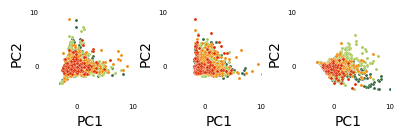

In [17]:
plt          = utils_plotting.get_figure_template()

ax_pca_pre   = plt.subplot2grid((77, 66), (0, 0) , colspan=10, rowspan=10)
ax_pca_event = plt.subplot2grid((77, 66), (0, 15) , colspan=10, rowspan=10)
ax_pca_post  = plt.subplot2grid((77, 66), (0, 30) , colspan=10, rowspan=10)

ax_pca_pre   = plot_PCA_projections(pre_data_pca, group_feature="severity", colors=colors, axis=ax_pca_pre)
ax_pca_event = plot_PCA_projections(event_data_pca, group_feature="severity", colors=colors, axis=ax_pca_event)
ax_pca_post  = plot_PCA_projections(post_data_pca, group_feature="severity", colors=colors, axis=ax_pca_post)

ax_pca_pre.set_xlim([-5,10])
ax_pca_event.set_xlim([-5,10])
ax_pca_post.set_xlim([-5,10])

ax_pca_pre.set_ylim([-5,10])
ax_pca_event.set_ylim([-5,10])
ax_pca_post.set_ylim([-5,10])

ax_pca_pre.set_xticklabels(ax_pca_pre.get_xticklabels(), fontsize=utils_plotting.LABEL_SIZE)
ax_pca_pre.set_yticklabels(ax_pca_pre.get_yticklabels(), fontsize=utils_plotting.LABEL_SIZE)
ax_pca_event.set_xticklabels(ax_pca_event.get_xticklabels(), fontsize=utils_plotting.LABEL_SIZE)
ax_pca_event.set_yticklabels(ax_pca_event.get_yticklabels(), fontsize=utils_plotting.LABEL_SIZE)
ax_pca_post.set_xticklabels(ax_pca_post.get_xticklabels(), fontsize=utils_plotting.LABEL_SIZE)
ax_pca_post.set_yticklabels(ax_pca_post.get_yticklabels(), fontsize=utils_plotting.LABEL_SIZE)

plt.savefig(DATA_IO.path_figure + 'pca/cortex_pca_projections.svg', dpi=300)

## 2. Plot Feature Loadings

In [19]:
colors_frequency = ["#B5179E", "#1DBCED", "#0154EF", "#EC096F"]

<Figure size 640x480 with 0 Axes>

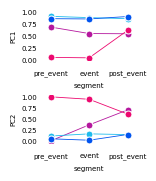

In [21]:
plt    = utils_plotting.get_figure_template()

ax_PC1 = plt.subplot2grid((77, 66), (0, 0), colspan=10, rowspan=6)
ax_PC2 = plt.subplot2grid((77, 66), (10, 0), colspan=10, rowspan=6)

ax_PC1 = sns.lineplot(data=df_pca_contributions, x="segment", y="PC1", hue="band", markers=True, palette=colors_frequency, 
                      marker="o", ax=ax_PC1, linewidth=0.6, markersize=5, legend=False)
ax_PC2 = sns.lineplot(data=df_pca_contributions, x="segment", y="PC2", hue="band", markers=True, palette=colors_frequency,
                      marker="o", ax=ax_PC2, linewidth=0.6, markersize=5, legend=False)

ax_PC1.set_yticks([0, 0.25, 0.50, 0.75, 1])
ax_PC2.set_yticks([0, 0.25, 0.50, 0.75, 1])
utils_plotting.set_axis(ax_PC1)
utils_plotting.set_axis(ax_PC2)
plt.savefig(DATA_IO.path_figure + 'pca/cortex_pca_loadings.svg', dpi=300)

## 2.3 Plot Explained Variance

<Figure size 640x480 with 0 Axes>

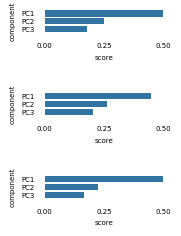

In [23]:
# create the radar chart
plt    = utils_plotting.get_figure_template()

ax_PC1 = plt.subplot2grid((77, 66), (0, 0), colspan=14, rowspan=3)
ax_PC2 = plt.subplot2grid((77, 66), (10, 0), colspan=14, rowspan=3)
ax_PC3 = plt.subplot2grid((77, 66), (20, 0), colspan=14, rowspan=3)

ax_PC1 = sns.barplot(data=pre_explained_variance, x="score", y="component", ax=ax_PC1)
ax_PC2 = sns.barplot(data=event_explained_variance, x="score", y="component", ax=ax_PC2)
ax_PC3 = sns.barplot(data=post_explained_variance, x="score", y="component", ax=ax_PC3)

utils_plotting.set_axis(ax_PC1)
utils_plotting.set_axis(ax_PC2)
utils_plotting.set_axis(ax_PC3)

ax_PC1.set_xticks([0, 0.25,0.5])
ax_PC2.set_xticks([0, 0.25,0.5])
ax_PC3.set_xticks([0, 0.25,0.5])

ax_PC1.set_xlim([0,0.5])
ax_PC2.set_xlim([0,0.5])
ax_PC3.set_xlim([0,0.5])

plt.savefig(DATA_IO.path_figure + 'pca/cortex_explained_variances.svg', dpi=300)

## 2.4 Plot CH Scores

<Figure size 640x480 with 0 Axes>

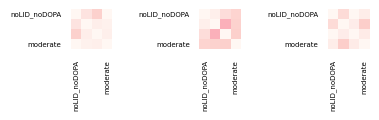

In [63]:
severity_mapping  = {'noLID_noDOPA':0, 'noLID_DOPA':1, 'mild':2, 'moderate':3}
ch_pre_event      = utils_statistics.ch_score(pre_data_pca[["PC1","severity"]], group_label="severity", group_mapping=severity_mapping)
ch_event          = utils_statistics.ch_score(event_data_pca[["PC1","severity"]], group_label="severity", group_mapping=severity_mapping)
ch_post_event     = utils_statistics.ch_score(post_data_pca[["PC1","severity"]], group_label="severity", group_mapping=severity_mapping)

plt      = utils_plotting.get_figure_template()

ax_pre   = plt.subplot2grid((77, 66), (0, 0), colspan=5, rowspan=5)
ax_event = plt.subplot2grid((77, 66), (0, 15), colspan=5, rowspan=5)
ax_post  = plt.subplot2grid((77, 66), (0, 30), colspan=5, rowspan=5)

ax_pre   = sns.heatmap(ch_pre_event, vmin=0, vmax=150, cmap="RdPu", ax=ax_pre, cbar=False, annot=False, annot_kws={"fontsize":5})
ax_event = sns.heatmap(ch_event, vmin=0, vmax=150, cmap="RdPu", ax=ax_event, cbar=False, annot=False, annot_kws={"fontsize":5})
ax_post  = sns.heatmap(ch_post_event, vmin=0, vmax=150, cmap="RdPu", ax=ax_post, cbar=False, annot=False, annot_kws={"fontsize":5})

utils_plotting.set_axis(ax_pre)
utils_plotting.set_axis(ax_event)
utils_plotting.set_axis(ax_post)

plt.savefig(DATA_IO.path_figure + 'pca/cortex_PC1_ch.svg', dpi=300)

In [65]:
np.max([ch_pre_event.max().max(), ch_event.max().max(), ch_post_event.max().max()])

47.8406823643074

<Figure size 640x480 with 0 Axes>

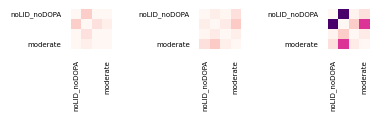

In [67]:
severity_mapping  = {'noLID_noDOPA':0, 'noLID_DOPA':1, 'mild':2, 'moderate':3}
ch_pre_event      = utils_statistics.ch_score(pre_data_pca[["PC2","severity"]], group_label="severity", group_mapping=severity_mapping)
ch_event          = utils_statistics.ch_score(event_data_pca[["PC2","severity"]], group_label="severity", group_mapping=severity_mapping)
ch_post_event     = utils_statistics.ch_score(post_data_pca[["PC2","severity"]], group_label="severity", group_mapping=severity_mapping)

plt      = utils_plotting.get_figure_template()

ax_pre   = plt.subplot2grid((77, 66), (0, 0), colspan=5, rowspan=5)
ax_event = plt.subplot2grid((77, 66), (0, 15), colspan=5, rowspan=5)
ax_post  = plt.subplot2grid((77, 66), (0, 30), colspan=5, rowspan=5)

ax_pre   = sns.heatmap(ch_pre_event, vmin=0, vmax=150, cmap="RdPu", ax=ax_pre, cbar=False, annot=False, annot_kws={"fontsize":5})
ax_event = sns.heatmap(ch_event, vmin=0, vmax=150, cmap="RdPu", ax=ax_event, cbar=False, annot=False, annot_kws={"fontsize":5})
ax_post  = sns.heatmap(ch_post_event, vmin=0, vmax=150, cmap="RdPu", ax=ax_post, cbar=False, annot=False, annot_kws={"fontsize":5})

utils_plotting.set_axis(ax_pre)
utils_plotting.set_axis(ax_event)
utils_plotting.set_axis(ax_post)

plt.savefig(DATA_IO.path_figure + 'pca/cortex_PC2_ch.svg', dpi=300)

In [53]:
np.max([ch_pre_event.max().max(), ch_event.max().max(), ch_post_event.max().max()])

155.96383225328916

In [71]:
ch_event


,noLID_noDOPA,noLID_DOPA,mild,moderate
noLID_noDOPA,0.000000,7.773966,1.348885,19.808682
noLID_DOPA,7.773966,0.000000,9.532862,33.877039
mild,1.348885,9.532862,0.000000,6.619643
moderate,19.808682,33.877039,6.619643,0.000000


In [73]:
ch_pre_event

,noLID_noDOPA,noLID_DOPA,mild,moderate
noLID_noDOPA,0.000000,31.375681,0.002132,0.000750
noLID_DOPA,31.375681,0.000000,17.830919,7.026086
mild,0.002132,17.830919,0.000000,0.000002
moderate,0.000750,7.026086,0.000002,0.000000
